In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import os 
import h5py
import sys
%matplotlib inline 

In [2]:
model_name = "Gaussian_scaling_phi.h5py"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'j7_eta', 'j7_phi','j7_m', 'j7_DL1r', 'j8_pt', 'j8_eta', 'j8_phi','j8_m', 'j8_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi','j7_phi','j7_phi', 'j8_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi']
# output_keys = ['th_eta','th_phi', 'tl_eta', 'tl_phi']

output_length = len(output_keys)
input_length = len(input_keys)

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
def phi_transform(arr):
    mean = np.mean(arr)
    arr = arr-mean
    max0 = np.max(arr)
    arr = arr/max0/2.2
    x, y = arr[0:len(arr)//2], arr[len(arr)//2:]
    s = x**2 + y**2 
    z1 = x/np.sqrt(s)*np.sqrt(-2*np.log(s))
    z2 = y/np.sqrt(s)*np.sqrt(-2*np.log(s))
    z = np.append(z1, z2)
    max1 = np.max(np.abs(z))
    z = z/max1
    
    return (z, max0, max1, mean)

def invphi_transform(z, max0, max1, mean):
    z = z*max1
    z1, z2 = z[0:len(z)//2], z[len(z)//2:]
    s1 = np.exp(-1*(z1**2+z2**2)/2)
    x1 = z1*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
    y1 = z2*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
    arr = np.append(x1, y1)
    arr = arr*max0*2.2+mean
    
    return arr 

def meanmax_transform(arr):
    mean = np.mean(arr)
    arr = arr-mean
    max0 = np.max(np.abs(arr))
    z = arr/max0
    return (z, max0, 0, mean)

def invmeanmax_transform(z, max0, max1, mean):
    return z*max0+mean
    
def scale_arrays(keys):
    arrays = []
    maxi0 = []
    maxi1 = []
    mean = []
    for x in keys:
        var = np.array(dataset.get(x))[0:crop0]
        if False:
            arr, max0, max1, mu = phi_transform(var)
        else:
            arr, max0, max1, mu = meanmax_transform(var)
        arrays.append(arr)
        maxi0.append(max0)
        maxi1.append(max1)
        mean.append(mu)
    arrays = np.stack(arrays, axis=1)
    return (arrays, maxi0, maxi1, mean)

def invscale_arrays(keys, maxi0, maxi1, mean, arrays):
    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        max0 = maxi0[i]
        max1 = maxi1[i]
        mu = mean[i]
        if False:
            total.append(invphi_transform(z, max0, max1, mu))
        else:
            total.append(invmeanmax_transform(z, max0, max1, mu))
    return np.stack(total,1) 

In [7]:
# Convert into numpy arrays and mean normalize
crop0 =  100000 # Must be even

total_input, in_max0, in_max1, in_mean = scale_arrays(input_keys)

total_output, out_max0, out_max1, out_mean = scale_arrays(output_keys)

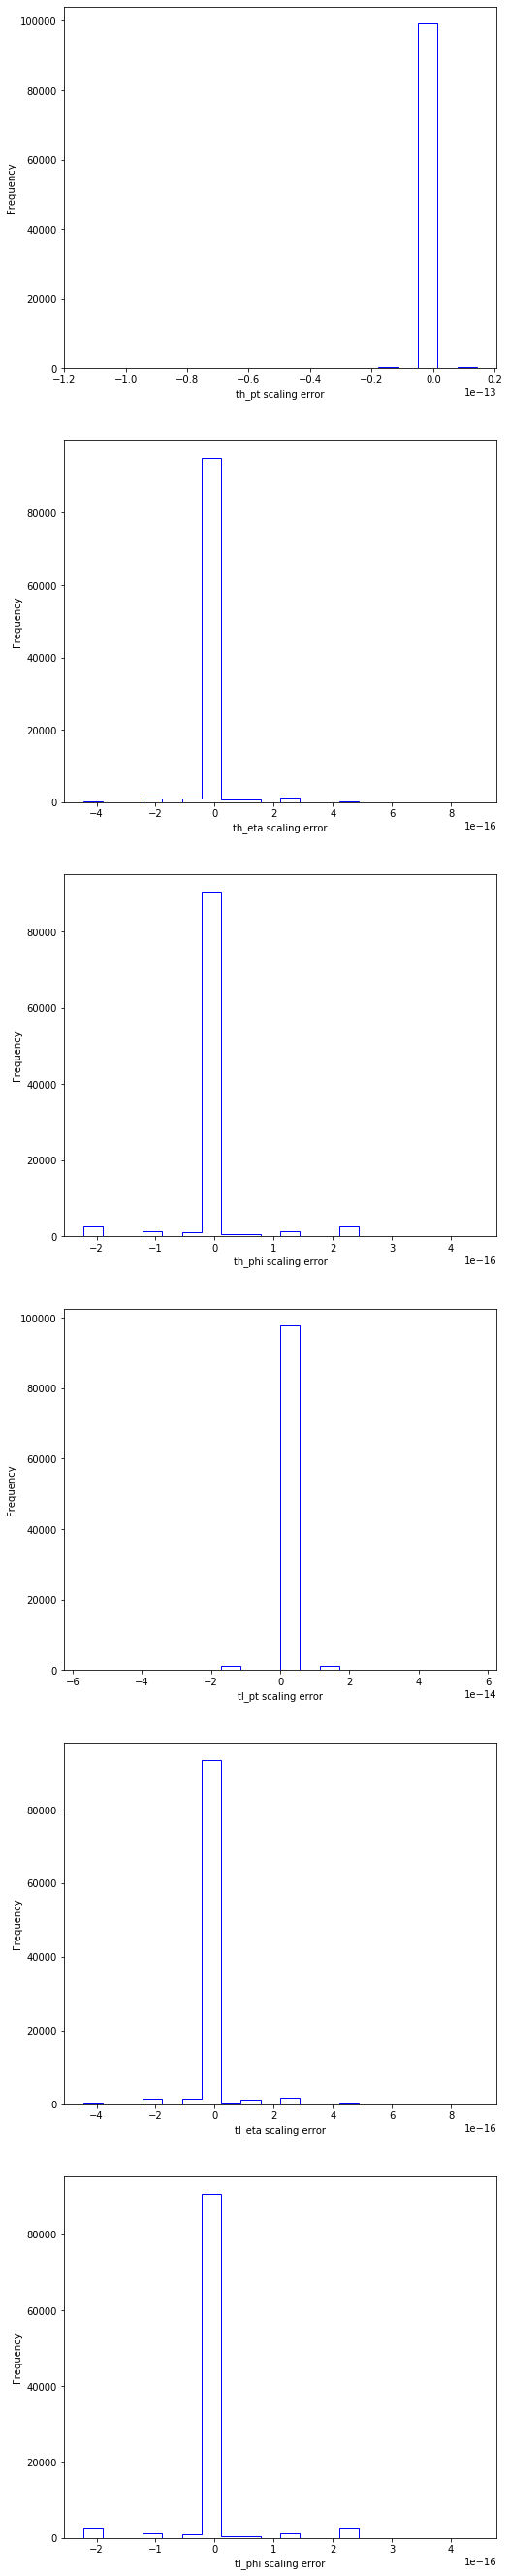

In [8]:
# Test inverse scaling

out_scaled = invscale_arrays(output_keys, out_max0, out_max1, out_mean, total_output)

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 45) (80000, 6)
(20000, 45) (20000, 6)


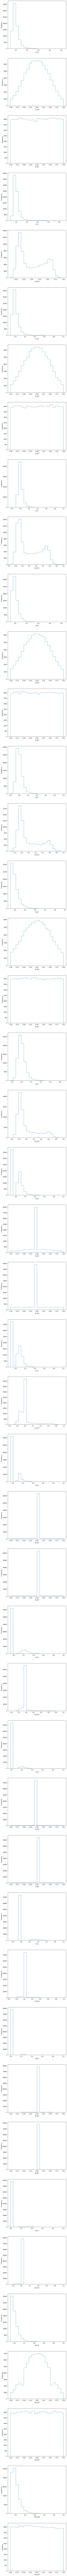

In [11]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [12]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23552     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 270,854
Trainable params: 270,854
Non-trainable params: 0
__________________________________________________

In [14]:
# Fit model

Epochs= 1024

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.2268 - mse: 0.1292 - val_loss: 0.2213 - val_mse: 0.1243
Epoch 2/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.2145 - mse: 0.1180 - val_loss: 0.2083 - val_mse: 0.1123
Epoch 3/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.2016 - mse: 0.1062 - val_loss: 0.1978 - val_mse: 0.1029
Epoch 4/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1935 - mse: 0.0991 - val_loss: 0.1926 - val_mse: 0.0988
Epoch 5/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1893 - mse: 0.0960 - val_loss: 0.1894 - val_mse: 0.0967
Epoch 6/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1864 - mse: 0.0942 - val_loss: 0.1869 - val_mse: 0.0953
Epoch 7/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1839 - mse: 0.0929 - val_loss: 0.1847 - val_mse: 0.0942
Epoch 8/1024
125/125 [==============================] - 1s 5ms

Epoch 62/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1333 - mse: 0.0761 - val_loss: 0.1375 - val_mse: 0.0804
Epoch 63/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1329 - mse: 0.0760 - val_loss: 0.1370 - val_mse: 0.0803
Epoch 64/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1324 - mse: 0.0758 - val_loss: 0.1366 - val_mse: 0.0802
Epoch 65/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1320 - mse: 0.0756 - val_loss: 0.1363 - val_mse: 0.0800
Epoch 66/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1316 - mse: 0.0755 - val_loss: 0.1359 - val_mse: 0.0799
Epoch 67/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1311 - mse: 0.0753 - val_loss: 0.1355 - val_mse: 0.0798
Epoch 68/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1307 - mse: 0.0752 - val_loss: 0.1351 - val_mse: 0.0797
Epoch 69/1024
125/125 [==============================] 

125/125 [==============================] - 1s 5ms/step - loss: 0.1068 - mse: 0.0655 - val_loss: 0.1173 - val_mse: 0.0760
Epoch 183/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1066 - mse: 0.0654 - val_loss: 0.1172 - val_mse: 0.0760
Epoch 184/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1065 - mse: 0.0653 - val_loss: 0.1172 - val_mse: 0.0760
Epoch 185/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1064 - mse: 0.0653 - val_loss: 0.1171 - val_mse: 0.0760
Epoch 186/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1063 - mse: 0.0652 - val_loss: 0.1170 - val_mse: 0.0760
Epoch 187/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1061 - mse: 0.0652 - val_loss: 0.1169 - val_mse: 0.0760
Epoch 188/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1060 - mse: 0.0651 - val_loss: 0.1169 - val_mse: 0.0760
Epoch 189/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0944 - mse: 0.0589 - val_loss: 0.1119 - val_mse: 0.0763
Epoch 303/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0944 - mse: 0.0588 - val_loss: 0.1118 - val_mse: 0.0763
Epoch 304/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0943 - mse: 0.0588 - val_loss: 0.1118 - val_mse: 0.0763
Epoch 305/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0942 - mse: 0.0587 - val_loss: 0.1118 - val_mse: 0.0763
Epoch 306/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0941 - mse: 0.0587 - val_loss: 0.1118 - val_mse: 0.0764
Epoch 307/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0940 - mse: 0.0586 - val_loss: 0.1117 - val_mse: 0.0764
Epoch 308/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0939 - mse: 0.0586 - val_loss: 0.1117 - val_mse: 0.0764
Epoch 309/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0854 - mse: 0.0528 - val_loss: 0.1107 - val_mse: 0.0781
Epoch 423/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0854 - mse: 0.0528 - val_loss: 0.1107 - val_mse: 0.0781
Epoch 424/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0853 - mse: 0.0527 - val_loss: 0.1107 - val_mse: 0.0781
Epoch 425/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0852 - mse: 0.0527 - val_loss: 0.1107 - val_mse: 0.0781
Epoch 426/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0852 - mse: 0.0526 - val_loss: 0.1107 - val_mse: 0.0781
Epoch 427/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0851 - mse: 0.0526 - val_loss: 0.1107 - val_mse: 0.0781
Epoch 428/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0850 - mse: 0.0525 - val_loss: 0.1107 - val_mse: 0.0782


In [15]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Gaussian_scaling_phi.h5py/assets


Text(0.5, 1.0, 'MSE loss')

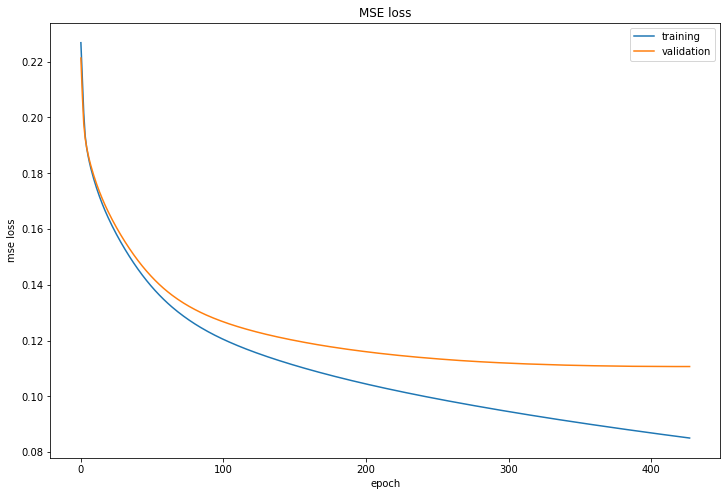

In [16]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [17]:
predictions = model.predict(test_input)
total_predictions = model.predict(total_input)

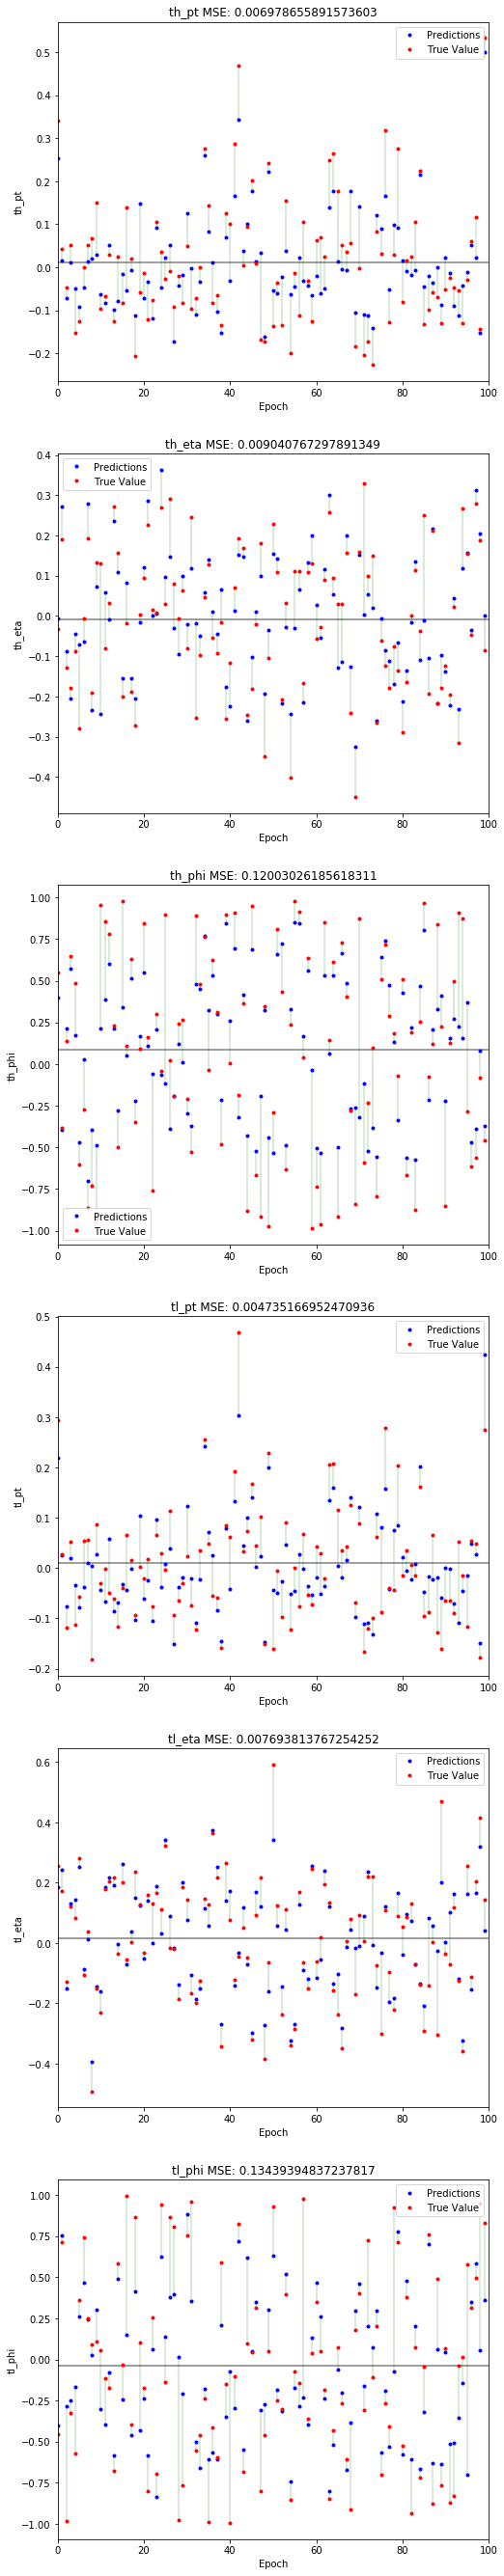

In [18]:
# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [19]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.07532854937453476
th_pt MSE :  0.0071970451
th_eta MSE :  0.0127871954
th_phi MSE :  0.2232739971
tl_pt MSE :  0.0052563077
tl_eta MSE :  0.0104221353
tl_phi MSE :  0.1930346156


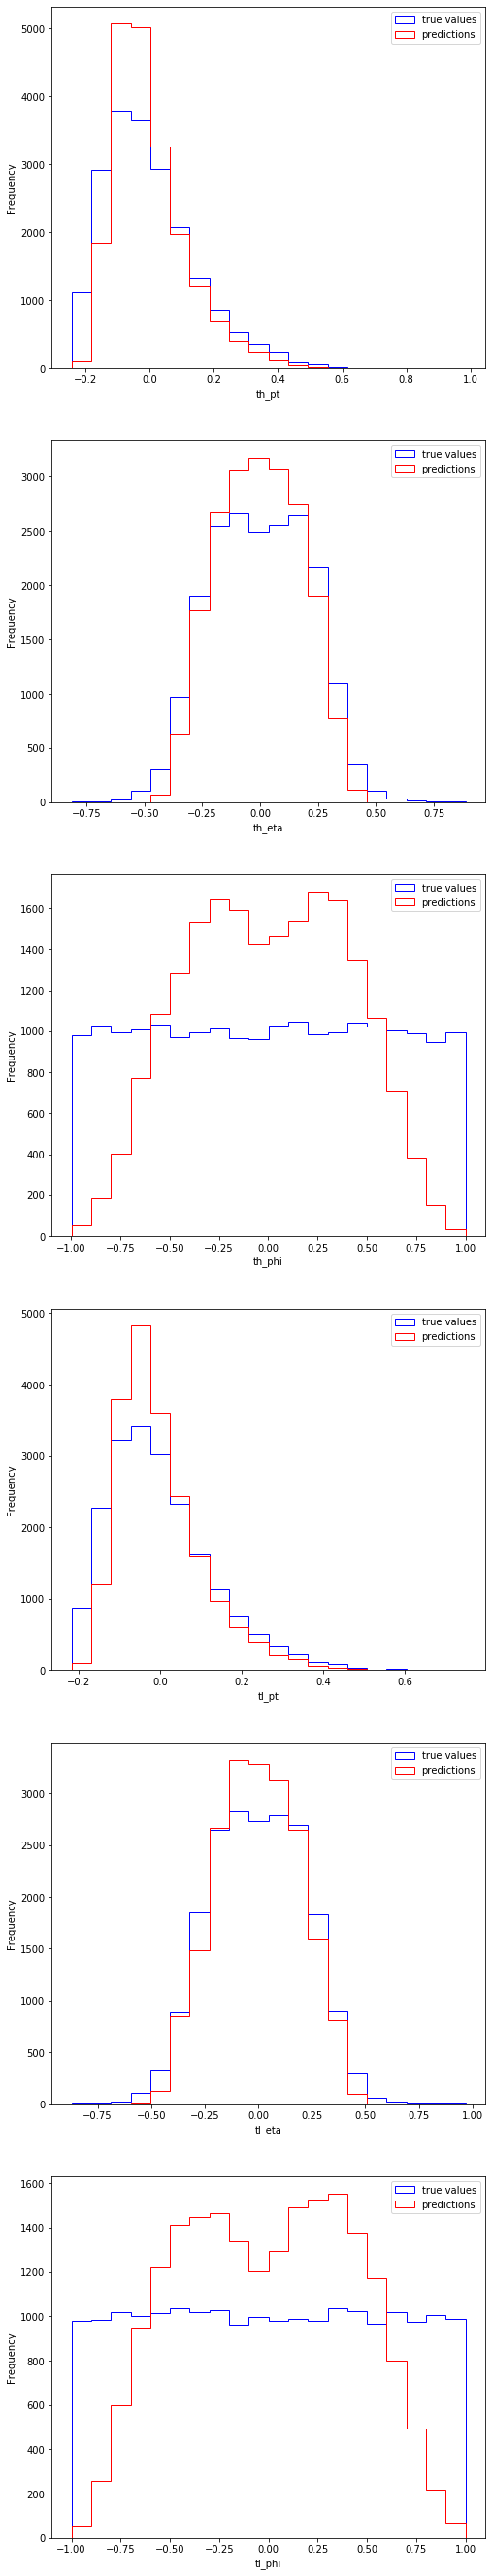

In [20]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values')
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions')
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [1]:
# Histograms to the original scale 

out_scaled = invscale_arrays(output_keys, out_max0, out_max1, out_mean, total_output)[split:,:]

predict_scaled = invscale_arrays(output_keys, out_max0, out_max1, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

NameError: name 'invscale_arrays' is not defined

In [22]:
for i in range(output_length):
    MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] -out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  2059.3585458077
Original Scale th_eta MSE :  0.7034219297
Original Scale th_phi MSE :  2.2086066197
Original Scale tl_pt MSE :  1904.4815995838
Original Scale tl_eta MSE :  0.5215354406
Original Scale tl_phi MSE :  1.9064368871
